# 01 — Load, QC, and Leveling (imu-sim → MAMMAL-ready)

Goal:
- Load imu-sim outputs (`sim_magnav.csv`, `trajectory.csv`)
- Sanity-check signals (time series + flight path)
- Prepare a MAMMAL-style `survey_df`
- Create synthetic flight-line labels (`line_id`)
- Run MAMMAL leveling (tie-line / PCA) and compare outputs


In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
#loading csvs
SIM_DIR = "../data/sim_data1"

df = pd.read_csv(f"{SIM_DIR}/sim_magnav.csv")
traj = pd.read_csv(f"{SIM_DIR}/trajectory.csv")

print("sim_magnav rows:", len(df))
print("trajectory rows:", len(traj))
df.head()


sim_magnav rows: 54250
trajectory rows: 54250


,time_s,lat,lon,alt_m,mag_scalar_nT,mag_anomaly_injected_nT,mag_residual_nT
0,0.00,-27.116237,131.084472,0.0,55380.742139,-2.317801,-31.873278
1,0.01,-27.116237,131.084472,0.0,55376.358266,-2.317801,-36.257151
2,0.02,-27.116237,131.084472,0.0,55401.958994,-2.317801,-10.656422
3,0.03,-27.116237,131.084472,0.0,55401.163495,-2.317801,-11.451921
4,0.04,-27.116237,131.084472,0.0,55442.389970,-2.317801,29.774553


In [3]:
#sanity checks
print("Columns:", df.columns.tolist())
print("time_s range:", df.time_s.min(), "→", df.time_s.max())

# Check monotonic time (should be increasing)
is_monotonic = np.all(np.diff(df.time_s.values) >= 0)
print("time_s monotonic:", is_monotonic)


Columns: ['time_s', 'lat', 'lon', 'alt_m', 'mag_scalar_nT', 'mag_anomaly_injected_nT', 'mag_residual_nT']
time_s range: 0.0 → 542.49
time_s monotonic: True


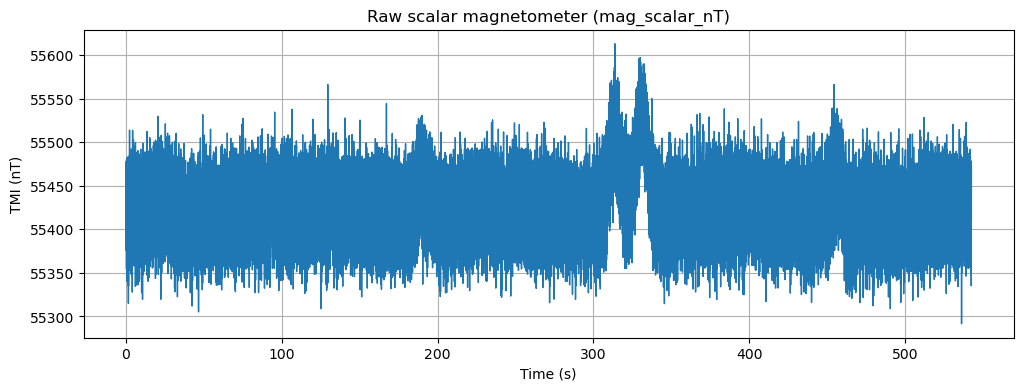

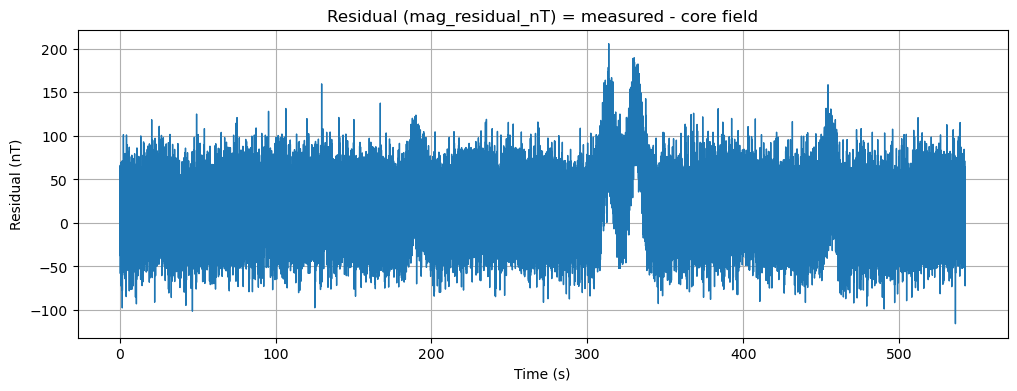

In [4]:
#plotting raw scalar values + residual vs time
plt.figure(figsize=(12,4))
plt.plot(df.time_s, df.mag_scalar_nT, linewidth=1)
plt.xlabel("Time (s)")
plt.ylabel("TMI (nT)")
plt.title("Raw scalar magnetometer (mag_scalar_nT)")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df.time_s, df.mag_residual_nT, linewidth=1)
plt.xlabel("Time (s)")
plt.ylabel("Residual (nT)")
plt.title("Residual (mag_residual_nT) = measured - core field")
plt.grid(True)
plt.show()


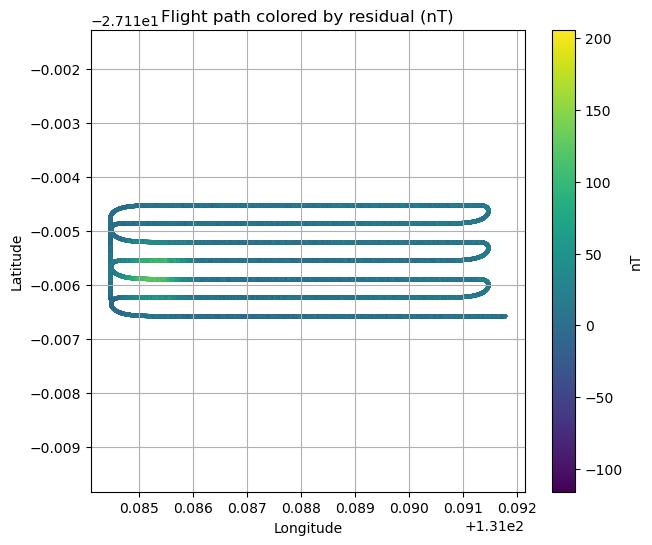

In [5]:
#plotting flight path colored by residual (for quick spatial intuition)
plt.figure(figsize=(7,6))
sc = plt.scatter(df.lon, df.lat, c=df.mag_residual_nT, s=4)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Flight path colored by residual (nT)")
plt.colorbar(sc, label="nT")
plt.axis("equal")
plt.grid(True)
plt.show()


In [6]:
import sys
!{sys.executable} -m pip install pymap3d


In [11]:
print("lat min/max:", df.lat.min(), df.lat.max())
print("lon min/max:", df.lon.min(), df.lon.max())
print("unique lat:", df.lat.nunique(), "out of", len(df))
print("unique lon:", df.lon.nunique(), "out of", len(df))
#dolat/lon
# how many repeats in a row?
same_pos = ((df.lat.diff().fillna(0)==0) & (df.lon.diff().fillna(0)==0)).mean()
print("Fraction of samples with identical lat/lon vs previous:", same_pos)


lat min/max: -27.11657512222636 -27.114518645119222
lon min/max: 131.084472 131.09177607828096
unique lat: 53249 out of 54250
unique lon: 50505 out of 54250
Fraction of samples with identical lat/lon vs previous: 0.018470046082949308


#checkingENUreading

In [12]:
print("east range (m):", df.east_m.min(), df.east_m.max())
print("north range (m):", df.north_m.min(), df.north_m.max())


east range (m): -6.935073348923737e-10 724.2360253660213
north range (m): -37.46783202182272 190.38984076831866


find first index where motion occurs

In [13]:
motion = np.sqrt(np.diff(df.east_m, prepend=df.east_m.iloc[0])**2 + np.diff(df.north_m, prepend=df.north_m.iloc[0])**2)
idx = np.argmax(motion > 0)  # first True index
print("first index with motion:", idx, "time:", df.time_s.iloc[idx], "motion step (m):", motion[idx])


first index with motion: 1002 time: 10.02 motion step (m): 9.999924356588917e-05


how much heading is changing

In [15]:
h = df["heading_deg"].values
dhead = (np.diff(h, prepend=h[0]) + 180) % 360 - 180

print("Per-sample |dhead| stats (deg):")
print("  max:", np.nanmax(np.abs(dhead)))
print("  mean:", np.nanmean(np.abs(dhead)))
print("  95%:", np.nanpercentile(np.abs(dhead), 95))

print("Overall heading range:", np.nanmin(h), "→", np.nanmax(h))


Per-sample |dhead| stats (deg):
  max: 0.5824980484924254
  mean: 0.021566332461552644
  95%: 0.15756361015816936
Overall heading range: 1.0800249583553523e-12 → 359.99999999999403


In [16]:
import numpy as np

h = df["heading_deg"].values

def wrap_diff_deg(a, b):
    # wrapped difference a-b in [-180, 180]
    return ((a - b + 180) % 360) - 180

# Window length in samples.
# Your dt is 0.01s, so:
#   W=500  -> 5 seconds lookahead
#   W=1000 -> 10 seconds lookahead
W = 800

# Turn score = total heading change over W samples
turn_score = np.zeros(len(h))
for i in range(len(h) - W):
    turn_score[i] = abs(wrap_diff_deg(h[i + W], h[i]))

df["turn_score_deg"] = turn_score

# Threshold: how much heading rotation over W counts as "turn".
# For U-turns, you'll see near ~180 deg over the turn region.
turn_total_thresh = 45.0
is_turn = df["turn_score_deg"].values > turn_total_thresh
df["is_turn"] = is_turn

# Create line_id: increment when we EXIT a turn
line_id = np.zeros(len(df), dtype=int)
current = 0
in_turn_prev = is_turn[0]

for i in range(1, len(df)):
    in_turn = is_turn[i]
    if in_turn_prev and not in_turn:
        current += 1
    line_id[i] = current
    in_turn_prev = in_turn

df["line_id"] = line_id

print("W:", W, "turn_total_thresh:", turn_total_thresh)
print("Num line segments:", df["line_id"].nunique())


W: 800 turn_total_thresh: 45.0
Num line segments: 8


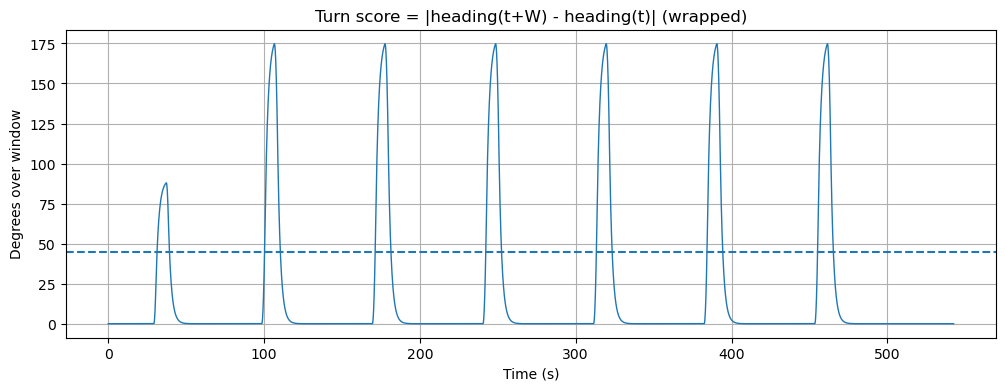

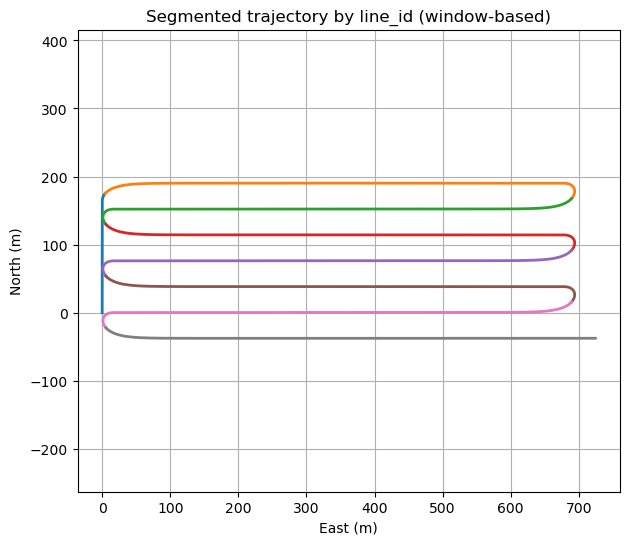

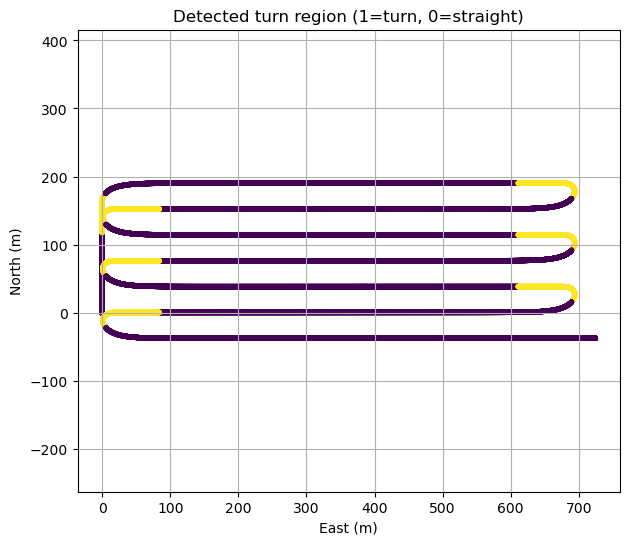

In [17]:
import matplotlib.pyplot as plt

# 1) Turn score vs time
plt.figure(figsize=(12,4))
plt.plot(df.time_s, df.turn_score_deg, linewidth=1)
plt.axhline(45, linestyle="--")
plt.title("Turn score = |heading(t+W) - heading(t)| (wrapped)")
plt.xlabel("Time (s)")
plt.ylabel("Degrees over window")
plt.grid(True)
plt.show()

# 2) Segmented ENU trajectory
plt.figure(figsize=(7,6))
for lid, g in df.groupby("line_id"):
    plt.plot(g.east_m, g.north_m, linewidth=2)
plt.title("Segmented trajectory by line_id (window-based)")
plt.xlabel("East (m)")
plt.ylabel("North (m)")
plt.axis("equal")
plt.grid(True)
plt.show()

# 3) Turn points on ENU plot
plt.figure(figsize=(7,6))
plt.scatter(df.east_m, df.north_m, c=df.is_turn.astype(int), s=8)
plt.title("Detected turn region (1=turn, 0=straight)")
plt.xlabel("East (m)")
plt.ylabel("North (m)")
plt.axis("equal")
plt.grid(True)
plt.show()


In [18]:
survey_df = pd.DataFrame({
    "LAT": df["lat"],
    "LONG": df["lon"],
    "ALT": df["alt_m"],
    "F": df["mag_residual_nT"],
    "line": df["line_id"].astype(str)
})
